# LIANA x Tensor-cell2cell Quickstart (Python)

This tutorial provides an abbreviated version of Tutorials 01-06 in order to give a quick overview of the pipeline to go from a raw counts matrix to downstream cell-cell communication (CCC) analyses. By combining LIANA and Tensor-cell2cell, we get a general framework that can robustly incorporate many existing CCC inference tools, ultimately retriving consensus communication scores for any sample and analyzing all those samples together to identify context-dependent communication programs.  

## Initial Setups

### Enabling GPU use

First, if you are using a NVIDIA GPU with CUDA cores, set `use_gpu=True` and enable PyTorch with the following code block. Otherwise, set `use_gpu=False` or skip this part

In [1]:
use_gpu = True

if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

### Libraries
Then, import all the packages we will use in this tutorial:

In [4]:
import cell2cell as c2c
import liana as li

import decoupler as dc
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
import plotnine as p9
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Directories

Afterwards, specify the data and output directories:

In [6]:
output_folder = '../../data/quickstart/outputs_pbmcs/'
c2c.io.directories.create_directory(output_folder)

../../data/quickstart/outputs_pbmcs/ was created successfully.


### Loading Data

We begin by loading the single-cell transcriptomics data. For this tutorial, we will use a dataset of ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018; GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). We use a convenient function to download the data and store it in the AnnData format, on which the [scanpy](https://scanpy.readthedocs.io/en/stable/) package is built.

In [7]:
adata = li.testing.datasets.kang_2018()

  0%|          | 0.00/36.6M [00:00<?, ?B/s]

## Preprocess Expression

Note, we do not include a batch correction step as Tensor-cell2cell can get robust decomposition results without this; however, we have extensive analysis and discuss regarding this topic in [Supplementary Tutorial 01](./S1_Batch_Correction.ipynb)

### Quality-Control Filtering

The loaded data has already been pre-processed to a degree and comes with cell annotations. Nevertheless, let’s highlight some of the key steps. To ensure that any noisy cells or features are removed, we filter any non-informative cells and genes:

In [8]:
# basic filters
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

We additionally remove high mitochondrial content:

In [9]:
# filter low quality cells with standard QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata,
                           qc_vars=['mt'],
                           percent_top=None,
                           log1p=False,
                           inplace=True)
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [10]:
adata

View of AnnData object with n_obs × n_vars = 24297 × 15688
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

### Normalization

Normalized counts are usually obtained in two essential steps, the first being count depth scaling which ensures that the measured count depths are comparable across cells. This is then usually followed up with log1p transformation, which essentially stabilizes the variance of the counts and enables the use of linear metrics downstream:

In [11]:
# save the raw counts to a layer
adata.layers["counts"] = adata.X.copy()

# Normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

Let's see what our data looks like:

In [12]:
adata.obs.head()

,nCount_RNA,nFeature_RNA,tsne1,tsne2,condition,cluster,cell_type,patient,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters,sample,cell_abbr,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
index,,,,,,,,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1,ctrl&1016,CD14,877,877,3017.0,0.0,0.0
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1,ctrl&1256,CD14,713,713,2481.0,0.0,0.0
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6,ctrl&1488,CD4T,337,337,703.0,0.0,0.0
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1,ctrl&1256,CD14,850,850,3420.0,0.0,0.0
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12,ctrl&1039,DCs,1111,1111,3158.0,0.0,0.0


Define columns to use for downstream analysis:

In [13]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_abbr'

## Deciphering Cell-Cell Communication

we will use LIANA to infer the ligand-receptor interactions for each sample. LIANA is  highly modularized and it natively implements the formulations of a number of methods, including CellPhoneDBv2, Connectome, log2FC, NATMI, SingleCellSignalR, CellChat, a geometric mean, as well as a consensus in the form of a rank aggregate from any combination of methods

In [14]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


LIANA classifies the scoring functions from the different methods into two categories: those that infer the “Magnitude” and “Specificity” of interactions. We define the “Magnitude” of an interaction as a measure of the strength of the interaction's expression, and the “Specificity” of an interaction is a measure of how specific an interaction is to a given pair of clusters. Generally, these categories are complementary, and the magnitude of the interaction is often a proxy of the specificity of the interaction. For example, a ligand-receptor interaction with a high magnitude score in a given pair of cell types is likely to also be specific, and vice versa.


When considering ligand-receptor prior knowledge resources, a common theme is the trade-off between coverage and quality, and similarly each resource comes with its own biases. In this regard, LIANA builds on OmniPath29 as any of the resources in LIANA are obtained via OmniPath. These include the expert-curated resources of CellPhoneDBv223, CellChat27, ICELLNET30, connectomeDB202025, CellTalkDB31, as well as 10 others. LIANA further provides a consensus expert-curated resource from the aforementioned five resources, along with some curated interactions from SignaLink. In this protocol, we will use the consensus resource from liana, though any of the other resources are available via LIANA, and one can also use liana with their own custom resource.

In [15]:
liana_resources = li.resource.show_resources()
print(*liana_resources, sep = ', ')

baccin2019, cellcall, cellchatdb, cellinker, cellphonedb, celltalkdb, connectomedb2020, consensus, embrace, guide2pharma, hpmr, icellnet, italk, kirouac2010, lrdb, mouseconsensus, ramilowski2015


Selecting any of the lists of ligand-receptor pairs in LIANA  can be done through the following command (here we select the aforementioned "consensus" resource:

In [16]:
lr_pairs = li.resource.select_resource('consensus')

<img src="https://github.com/saezlab/liana/blob/master/vignettes/ligrec_pipe.png?raw=true" width="900"/>

Next, we can run LIANA on each sample across the available methods. By default, LIANA calculates an aggregate rank across these mtehods using a re-implementation of the [RobustRankAggregate]('https://doi.org/10.1093/bioinformatics/btr709') method, and generates a probability distribution for ligand-receptors that are ranked consistently better than expected under a null hypothesis (See Appendix 2). The consensus of ligand-receptor interactions across methods can therefore be treated as a p-value.

In [17]:
li.mt.rank_aggregate.by_sample(adata,
                               sample_key=sample_key,
                               groupby=groupby,
                               resource_name = 'consensus',
                               expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                               min_cells = 5,
                               n_perms = 100,
                               use_raw = False, # run on log- and library-normalized counts
                               verbose = True,
                               inplace = True,
                               return_all_lrs=True, # return all LR values
                              )

Converting `sample` to categorical!
Now running: stim&1488: 100%|█████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:24<00:00,  5.30s/it]


The parameterrs used here are as follows:
    
- `adata` stands for Anndata, and we pass here with an object with a single  sample/context.
- `resource_name` is the name of any of the resources available in liana
- `groupby` corresponds to the cell group label stored in `adata.obs`.
- `use_raw` is boolean that indicates whether to use the `adata.raw` slot, here the log-normalized counts are assigned to `adata.X`, other options include passing the name of a layer via the `layer` parameter or using the counts stored in `adata.raw`.
- `expr_prop` is the expression proportion threshold  (in terms of cells per cell type expressing the protein)threshold of expression for any protein subunit involved in the interaction, according to which we keep or discard the interactions.
- `min_cells` is the minimum number of cells per cell type required for a cell type to be considered in the analysis
- `verbose` is a boolean that indicates whether to print the progress of the function
- `inplace` is a boolean that indicates whether storing the results in place, i.e. to `adata.uns[“liana_res”]`.

Let's see what the results look like:

In [18]:
adata.uns['liana_res'].head()

,sample,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
0,ctrl&101,FGR3,CD14,TIMP1,CD63,2.634805,0.0,6.247571,1.544213,2.285625,0.132291,0.984058,0.268787,0.0,6.401877e-09,1.325768e-12
1,ctrl&101,FGR3,DCs,TIMP1,CD63,2.321779,0.0,4.076271,1.154960,1.413446,0.086314,0.980338,0.199095,0.0,8.764034e-09,8.484083e-11
2,ctrl&101,CD14,CD14,TIMP1,CD63,2.261914,0.0,4.904150,1.277493,1.908720,0.103844,0.982043,0.225244,0.0,6.401877e-09,1.548535e-10
3,ctrl&101,NK,CD8T,B2M,CD3D,2.319840,0.0,2.631051,1.018839,0.661349,0.079802,0.975643,0.143878,0.0,1.773842e-08,9.029901e-10
4,ctrl&101,NK,NK,B2M,KLRD1,2.337043,0.0,2.767930,1.685281,0.911614,0.096133,0.976239,0.136489,0.0,6.401877e-09,9.662321e-10


This dataframe provides the results from running each method, as well as the consensus scores across the methods. In our case, we are interested in the magnitude consensus scored denoted by the `'magnitude_rank'` column.

We can visualize the output as a dotplot across multiple samples:

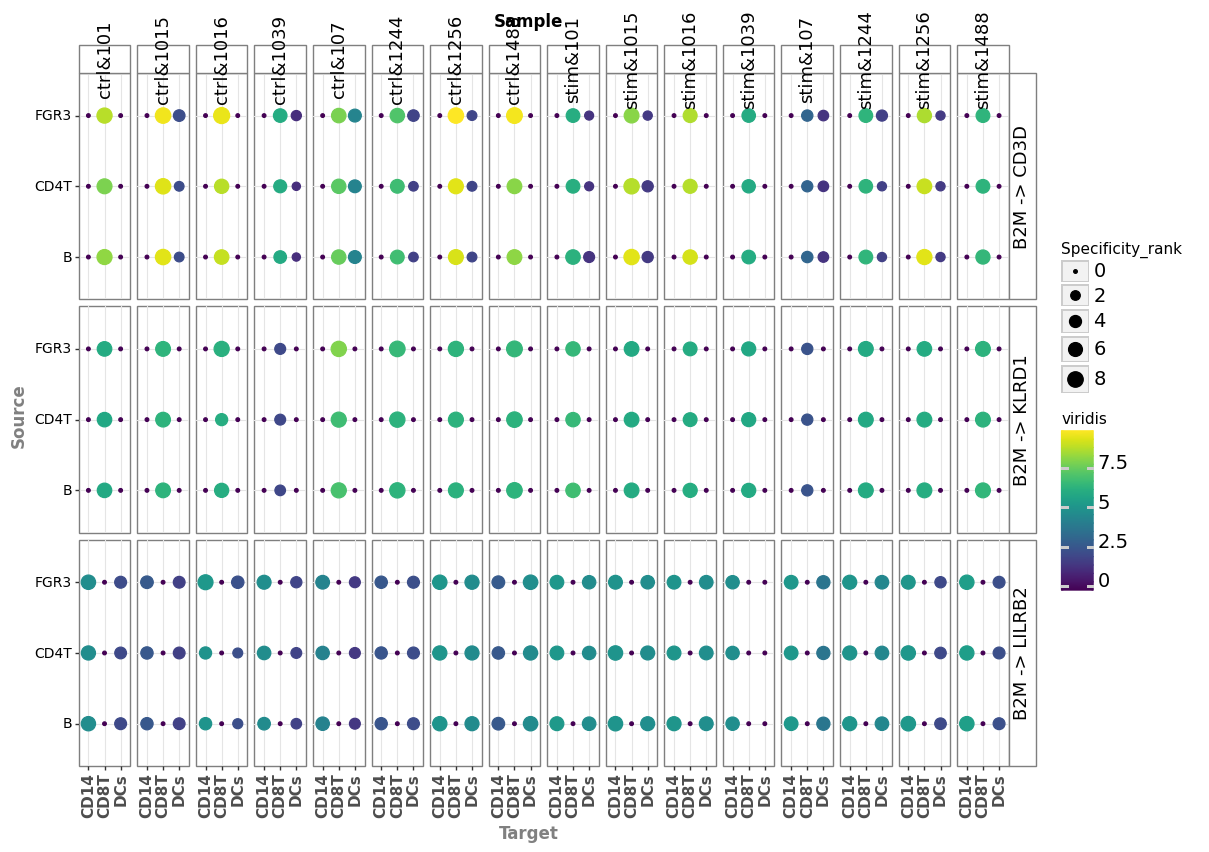

<ggplot: (8785910070276)>

In [19]:
li.pl.dotplot_by_sample(adata=adata,
                        colour='magnitude_rank',
                        size='specificity_rank',
                        source_labels=["CD4T", "B", "FGR3"],
                        target_labels=["CD8T", 'DCs', 'CD14'],
                        ligand_complex = 'B2M',
                        receptor_complex=["KLRD1", "LILRB2", "CD3D"],
                        sample_key=sample_key,
                        inverse_colour=True,
                        inverse_size=True,
                        figure_size=(12, 9),
                        size_range=(1, 6),
                        )

The key parameters used here are:

- `source_labels` is a list containing the names of the sender cells of interest.
- `target_labels` is a list containing the names of the receiver cells of interest.
- `ligand_complex` is a list containing the names of the ligands of interest.
- `receptor_complex` is a list containing the names of the receptors of interest.
- `sample_key` is a string containing the column name where samples are specified.

Let's export it in case we want to access it later:

In [20]:
adata.uns['liana_res'].to_csv(output_folder + '/LIANA_by_sample.csv', index=False)

Alternatively, one could just export the whole AnnData object, together with the ligand-receptor results stored:

In [21]:
adata.write_h5ad(output_folder + '/adata_processed.h5ad', compression='gzip')

## Comparing cell-cell communication across multiple samples

We can use Tensor-cell2cell to infer context-dependent CCC patterns from multiple samples simultaneously. To do so, we must first restructure the communication scores (LIANA's output) into a 4D-Communication Tensor.

The tensor is built as follows: we create matrices with the communication scores for each of the ligand-receptor pairs within the same sample, then generate a 3D tensor for each sample, and finally concatenate them to form the 4D tensor:

![ccc-scores](https://github.com/earmingol/cell2cell/blob/master/docs/tutorials/ASD/figures/4d-tensor.png?raw=true)

First, we generate a list containing all samples from our AnnData object. Here, we can find the names of each of the samples in the `sample` column of the adata.obs information:

In [22]:
sorted_samples = sorted(adata.obs[sample_key].unique())

Then we can directly pass the communication scores from LIANA to build the 3D tensors for each sample (panel c in last figure), and concatenate them, with the following function:

In [23]:
# build the tensor
tensor = li.multi.to_tensor_c2c(liana_res=adata.uns['liana_res'], # LIANA's dataframe containing results
                                sample_key=sample_key, # Column name of the samples
                                source_key='source', # Column name of the sender cells
                                target_key='target', # Column name of the receiver cells
                                ligand_key='ligand_complex', # Column name of the ligands
                                receptor_key='receptor_complex', # Column name of the receptors
                                score_key='magnitude_rank', # Column name of the communication scores to use
                                inverse_fun=lambda x: 1 - x, # Transformation function
                                how='outer_cells', # What to include across all samples
                                outer_fraction=1/3, # Fraction of samples as threshold to include cells and LR pairs.
                                context_order=sorted_samples, # Order to store the contexts in the tensor
                               )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.47s/it]


The key parameters when building a tensor are:

- `liana_res` is the dataframe containing the results from LIANA, usually located in `adata.uns[‘liana_res’]. We can pass directly the AnnData object to the parameter adata in this function. If the AnnData object is passed, we do not need to specify the liana_res parameter.

- `sample_key`, `source_key`, `target_key`, `ligand_key`, `receptor_key`, and `score_key` are the column names in the dataframe containing the samples, sender cells, receiver cells, ligands, receptors, and communication scores, respectively. Each row of the dataframe contains a unique combination of these elements.

- `inverse_fun` is the function we use to convert the communication score before using it to build the tensor. In this case, the 'magnitude_rank' score generated by LIANA considers low values as the most important ones, ranging from 0 to 1. In contrast, Tensor-cell2cell requires higher values to be the most important scores, so here we pass a function (`lambda x: 1 - x`) to adapt LIANA's magnitude-rank scores (subtracts the LIANA's score from 1). If `None` is passed instead, no transformation will be performed on the communication score. If using other scores coming from one of the methods implemented in LIANA, a similar transformation can be done depending on the parameters and assumptions of the scoring method.

- `how` controls which ligand-receptor pairs and cell types to include when building the tensor. This decision depends on whether the missing values across a number of samples for both ligand-receptor interactions and sender-receiver cell pairs are considered to be biologically-relevant. Options are:
    - `'inner'` is the more strict option since it only considers only cell types and LR pairs that are present in all contexts (intersection).
    - `'outer'` considers all cell types and LR pairs that are present across contexts (union).
    - `'outer_lrs'` considers only cell types that are present in all contexts (intersection), while all LR pairs that are present across contexts (union).
    - `'outer_cells'` considers only LR pairs that are present in all contexts (intersection), while all cell types that are present across contexts (union).

- `outer_fraction` controls the elements to include in the union scenario of the `how` options. Only elements that are present at least in this fraction of samples/contexts will be included. When this value is 0, the tensor includes all elements across the samples. When this value is 1, it acts as using `how='inner'`.

- `context_order` is a list specifying the order of the samples. The order of samples does not affect the results, but it is useful for posterior visualizations.

We can check the shape of this tensor to verify the number of samples, LR pairs, sender cells, adn receiver cells, respectively:

In [24]:
tensor.shape

torch.Size([16, 435, 7, 7])

In addition, optionally we can generate the metadata for coloring the elements in each of the tensor dimensions (i.e., for each of the contexts/samples, ligand-receptor pairs, sender cells, and receiver cells). For this, we have to pass dictionaries for each dimension containing the elements and their respective major groups. In cases where we do not account with such information, we do not need to generate such dictionaries. For the contexts/samples dictionary, we can use the metadata in the AnnData object. This information will be used later for visualization of the results.

In this example dataset, we can find samples in the column `'sample'`, while the condition groups are found in the column `'condition'`:

In [25]:
context_dict = adata.obs.sort_values(by=sample_key) \
                        .set_index(sample_key)[condition_key] \
                        .to_dict()

Then, the metadata can be generated with:

In [26]:
dimensions_dict = [context_dict, None, None, None]
meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=dimensions_dict,
                                                  fill_with_order_elements=True
                                                 )

We can export our tensor and its metadata:

In [27]:
c2c.io.export_variable_with_pickle(variable=tensor,
                                   filename=output_folder + '/Tensor.pkl')
c2c.io.export_variable_with_pickle(variable=meta_tensor,
                                   filename=output_folder + '/Tensor-Metadata.pkl')

../../data/quickstart/outputs_pbmcs//Tensor.pkl  was correctly saved.
../../data/quickstart/outputs_pbmcs//Tensor-Metadata.pkl  was correctly saved.


Then, we can load them with:

In [28]:
tensor = c2c.io.read_data.load_tensor(output_folder + '/Tensor.pkl')
meta_tensor = c2c.io.load_variable_with_pickle(output_folder + '/Tensor-Metadata.pkl')

## Perform Tensor Factorization

Now that we have built the tensor and its metadata, we can run Tensor Component Analysis via Tensor-cell2cell with one simple command that we implemented for our unified framework:

Running Elbow Analysis


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:34<00:00,  8.57s/it]


The rank at the elbow is: 6
Running Tensor Factorization
Generating Outputs
Loadings of the tensor factorization were successfully saved into ../../data/quickstart/outputs_pbmcs//Loadings.xlsx


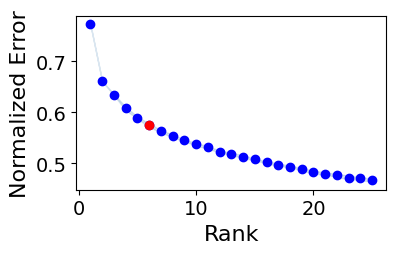

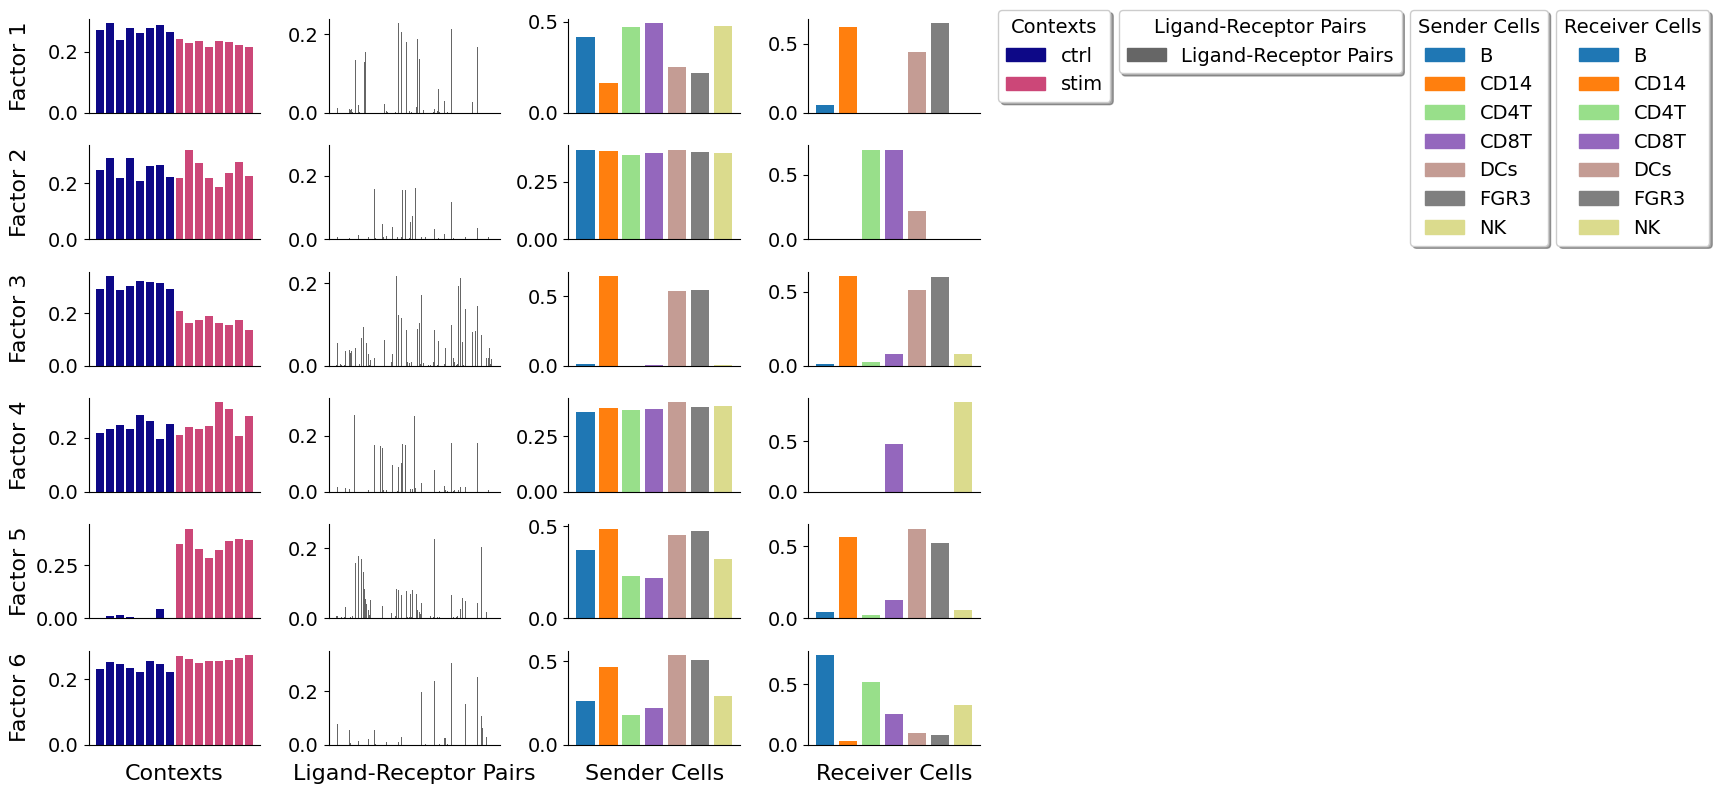

In [29]:
c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                           meta_tensor,
                                           rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                           tf_optimization='regular', # To define how robust we want the analysis to be.
                                           random_state=0, # Random seed for reproducibility
                                           device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                           output_folder=output_folder, # Whether to save the figures in files. If so, a folder pathname must be passed
                                          )

**Key parameters are:**

- `rank`  is the number of factors or latent patterns we want to obtain from the analysis. You can either indicate a specific number or leave it as `None` to perform the decomposition with a suggested number from an elbow analysis.

- `tf_optimization` indicates whether running the analysis in the `'regular'` or the `'robust'` way. The `'regular'` way runs the tensor decomposition less number of times than the robust way to select an optimal result. Additionally, the former employs less strict convergence parameters to obtain optimal results than the latter, which is also translated into a faster generation of results. **Important**: When using `tf_optimization='robust'` the analysis takes much longer to run than using `tf_optimization='regular'`. However, the latter may generate less robust results.

- `random_state` is the seed for randomization. It controls the randomization used when initializing the optimization algorithm that performs the tensor decomposition. It is useful for reproducing the same result every time that the analysis is run. If `None`, a different randomization will be used each time.


- `device` indicates whether we are using the `'cpu'` or a GPU with `'cuda'` cores.

- `output_folder` is the full path to the folder where the results will be saved. Make sure that this folder exists before passing it here.

The figure representing the loadings in each factor generated here can be interpreted by interconnecting all dimensions within a single factor. For example, if we take one of these factors, the cell-cell communication program occurs in each sample proportionally to their loadings. Then, this signature can be interpreted with the loadings of the ligand-receptor pairs, sender cells, and receiver cells. Ligands in high-loading ligand-receptor pairs are sent predominantly by high-loading sender cells, and interact with the cognate receptors on the high-loadings receiver cells.

### Downstream Visualizations: Making sense of the factors

After running the decomposition, the results are stored in the `factors` attribute of the tensor object. This attribute is a dictionary containing the loadings for each of the elements in every tensor dimension. Loadings delineate the importance of that particular element to that factor. Keys are the names of the different dimension.

In [30]:
tensor.factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

We can inspect the loadings of the samples, for example, located under the key `'Contexts'`:

In [31]:
tensor.factors['Contexts']

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
ctrl&101,0.270332,0.247286,0.292592,0.215103,4.010570e-10,0.231475
ctrl&1015,0.291630,0.291086,0.341411,0.233093,1.044283e-02,0.250662
ctrl&1016,0.238585,0.217481,0.288124,0.247691,1.342540e-02,0.246392
ctrl&1039,0.275843,0.289148,0.302774,0.231855,4.795332e-03,0.233603
ctrl&107,0.259571,0.206496,0.321550,0.283955,1.288960e-06,0.221600
ctrl&1244,0.277072,0.260974,0.317252,0.261879,9.721018e-05,0.254720
ctrl&1256,0.286455,0.266752,0.315117,0.195056,4.492147e-02,0.244827
ctrl&1488,0.265057,0.222111,0.292968,0.249131,5.467816e-06,0.222546
stim&101,0.239308,0.220685,0.207800,0.210447,3.497421e-01,0.270802
stim&1015,0.226724,0.319908,0.161027,0.238773,4.213534e-01,0.260401


In [32]:
tensor.factors['Sender Cells']

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
B,0.416015,0.385384,0.010189,0.358390,0.367898,0.263979
CD14,0.164361,0.382299,0.645374,0.376272,0.484843,0.467544
CD4T,0.469885,0.365400,0.000145,0.367074,0.229020,0.175351
CD8T,0.490371,0.374164,0.002215,0.373320,0.220655,0.221917
DCs,0.254085,0.388060,0.534771,0.402502,0.452011,0.538169
FGR3,0.218537,0.376688,0.545346,0.381490,0.470661,0.507878
NK,0.475756,0.373264,0.001327,0.385126,0.320317,0.290097


## Downstream Visualizations

We can use these loadings to compare pairs of sample major groups with boxplots and statistical tests:

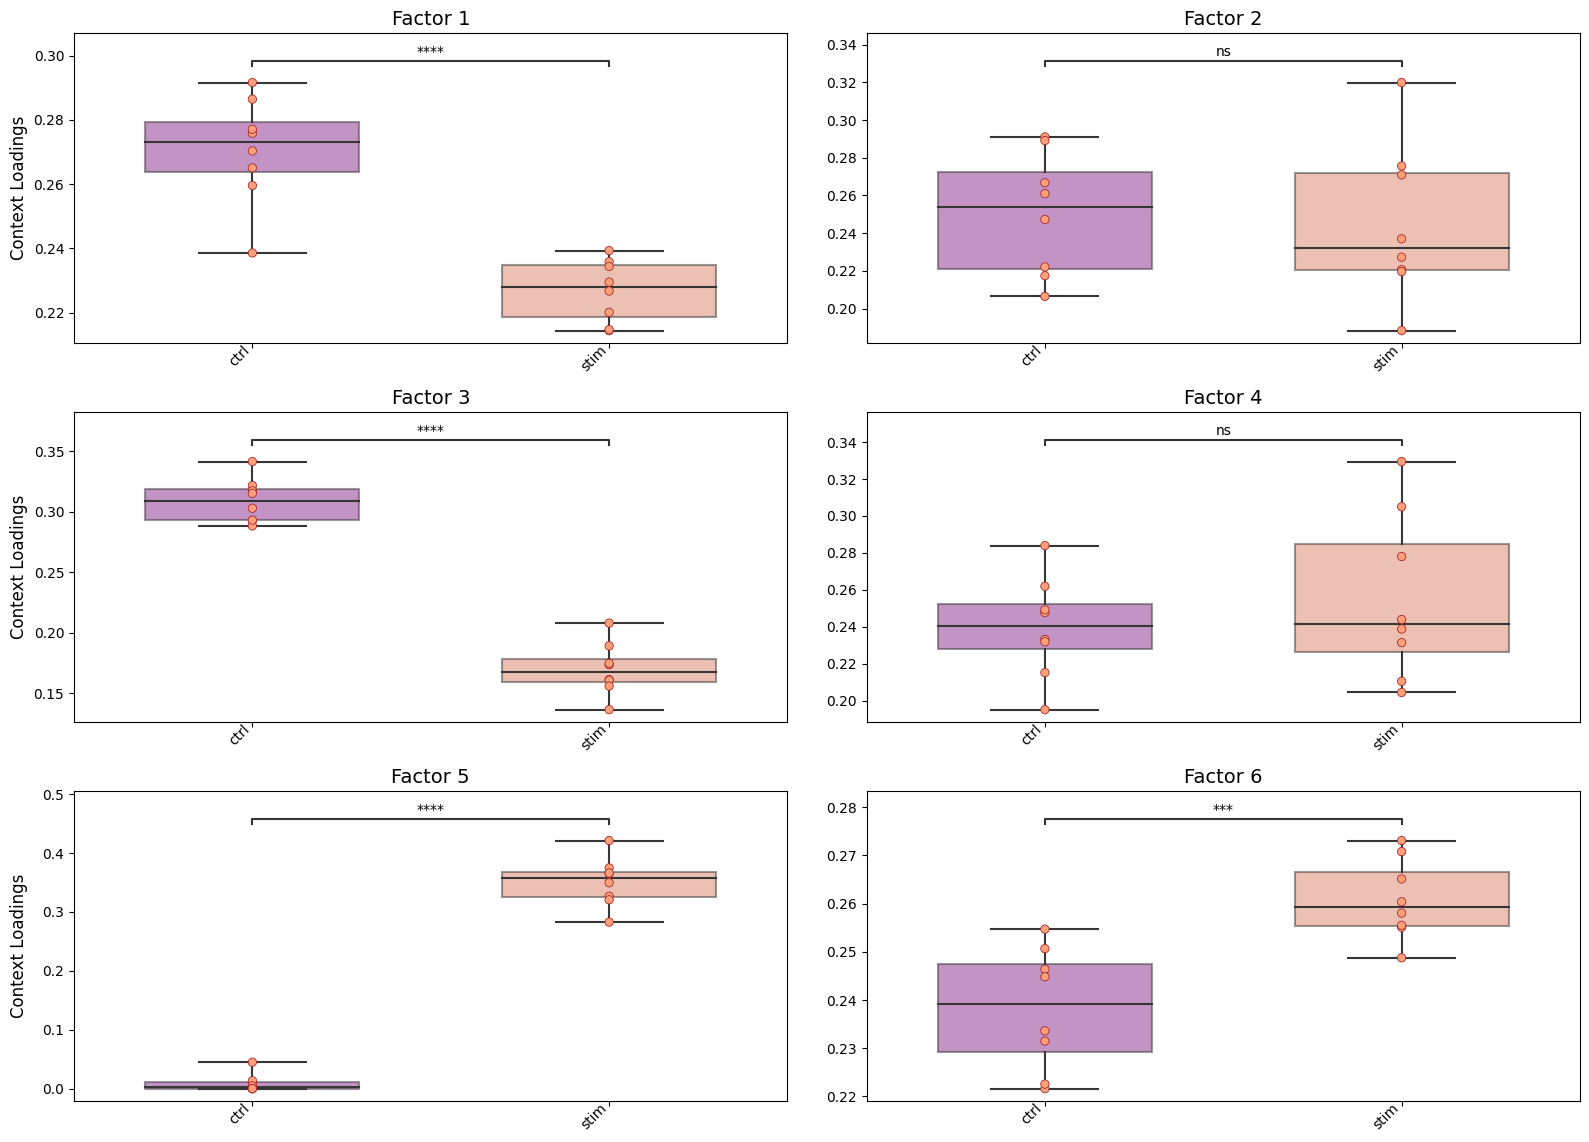

In [33]:
fig_filename = output_folder + '/PBMCs-Boxplots.pdf'

_ = c2c.plotting.context_boxplot(context_loadings=tensor.factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=3,
                                 figsize=(16, 12),
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap='plasma',
                                 verbose=False,
                                 filename=fig_filename
                                )

Using the loadings for any dimension, we can also generate heatmaps for the elements with loadings above a certain threshold. Additionally, we can cluster these elements by the similarity of their loadings across all factors:

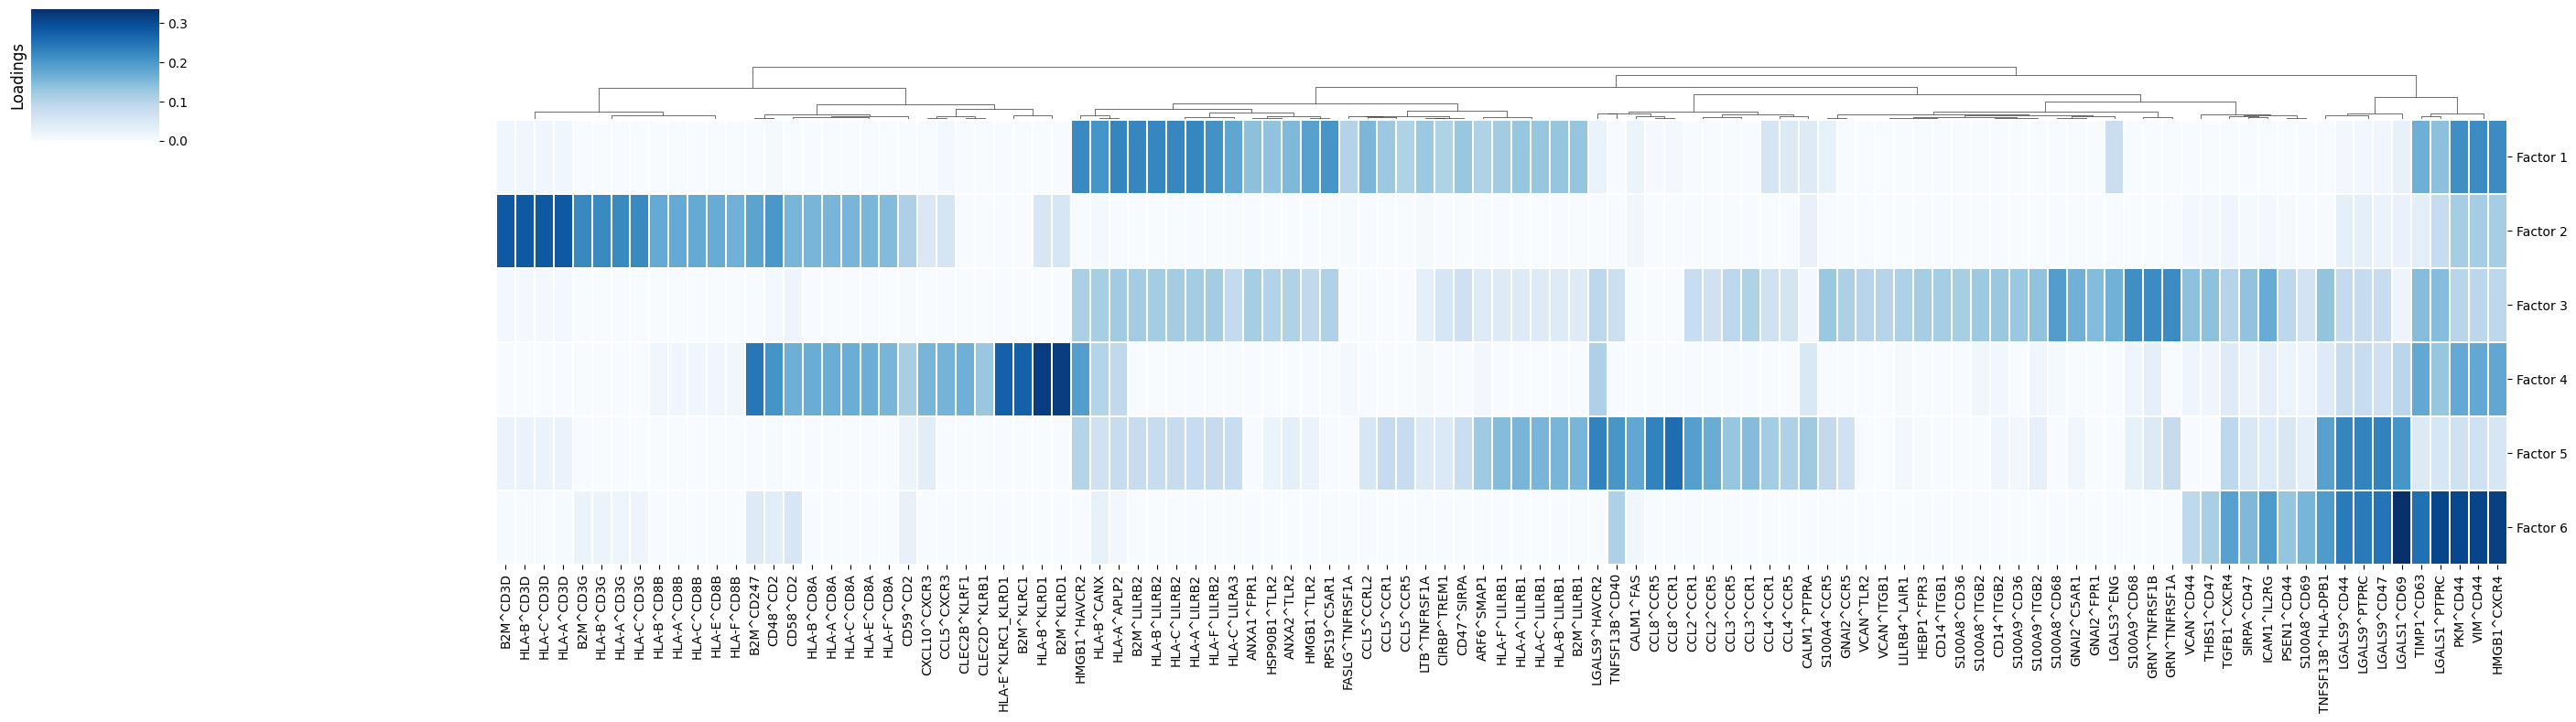

In [34]:
fig_filename = output_folder + '/Clustermap-LRs.pdf'

_ = c2c.plotting.loading_clustermap(loadings=tensor.factors['Ligand-Receptor Pairs'],
                                    loading_threshold=0.1,
                                    use_zscore=False,
                                    figsize=(28, 8),
                                    filename=fig_filename,
                                    row_cluster=False
                                   )

Here patients are grouped by the importance that each communication pattern (factor) has in relation to the other patients. This captures combinations of related communication patterns that explain similarities and differences at a sample-specific resolution.

### Overall CCI potential: Heatmap and network visualizations of sender-receiver cell pairs

In addition, we can also evaluate the overall interactions between sender-receiver cell pairs that are determinant for a given factor or program. We can do it through a heatmap where the X-axis represent the receiver cells and the Y-axis shows the receiver cells. Here, the potential of interaction is calculated as the outer product between the loadings for the sender and receiver cells dimensions of a particular factor. To illustrate this, we chose Factor 3, but this can be repeated for every factor obtained in the decomposition.

In [35]:
selected_factor = 'Factor 3'

In [36]:
loading_product = c2c.analysis.tensor_downstream.get_joint_loadings(tensor.factors,
                                                                    dim1='Sender Cells',
                                                                    dim2='Receiver Cells',
                                                                    factor=selected_factor,
                                                                   )

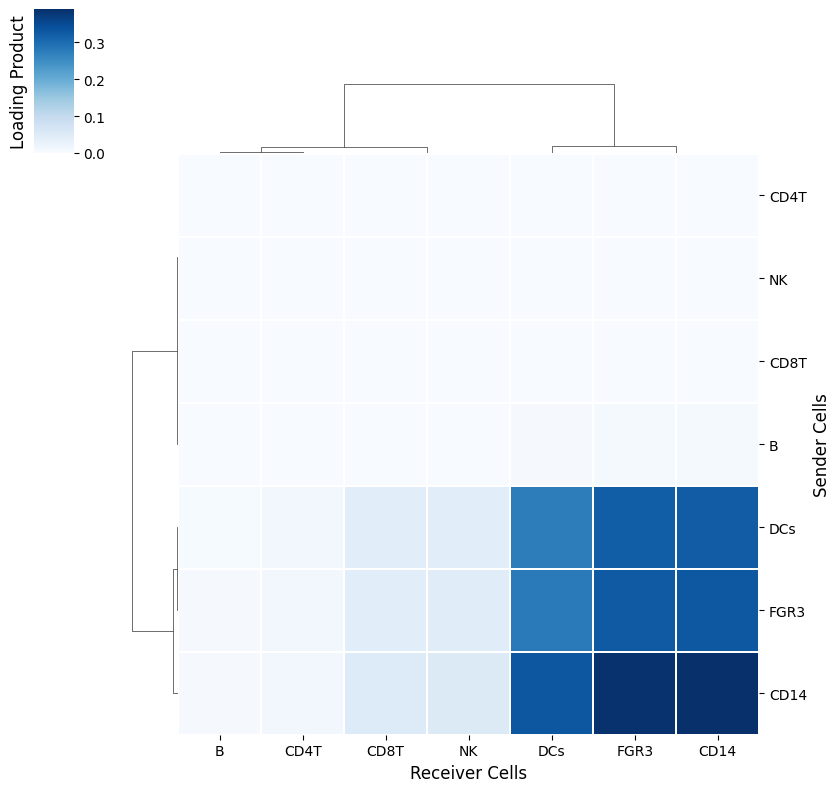

In [37]:
lprod_cm = c2c.plotting.loading_clustermap(loading_product.T, # Remove .T to transpose the axes
                                           use_zscore=False, # Whether standardizing the loadings across factors
                                           figsize=(8, 8),
                                           filename=output_folder + 'Clustermap-CC-Pairs.pdf',
                                           cbar_label='Loading Product',
                                          )

Similarly, an interaction network can be created for each factor by using the loading product between sender and receiver cells. First we need to choose a threshold to indicate what pair of cells are interacting. This can be done as shown in [the extended tutorial](./05-Downstream-Visualizations.ipynb)

In [38]:
threshold = 0.075

Then, we can plot all networks we are interested in:

(<Figure size 4800x1600 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Factor 3'}>,
        <AxesSubplot:title={'center':'Factor 4'}>,
        <AxesSubplot:title={'center':'Factor 5'}>], dtype=object))

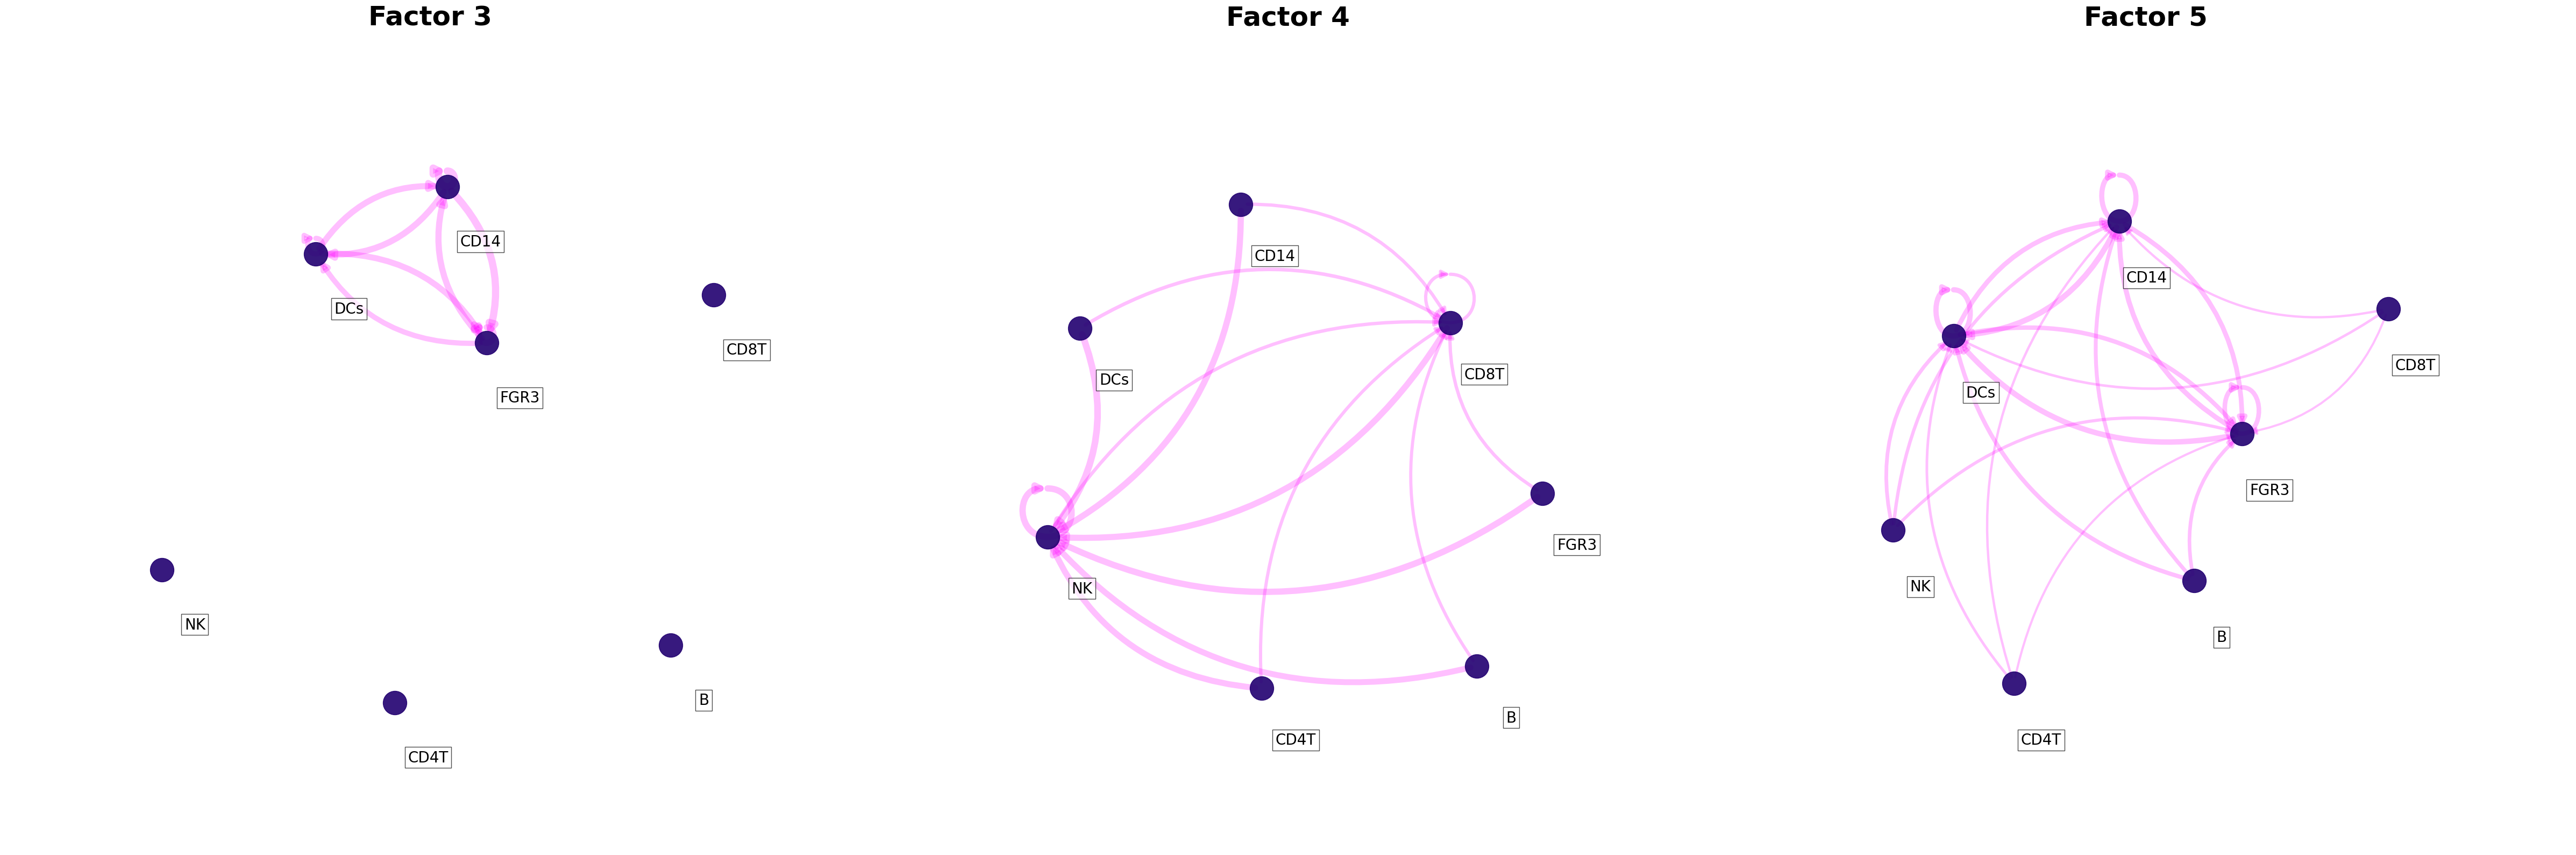

In [39]:
c2c.plotting.ccc_networks_plot(tensor.factors,
                               included_factors=['Factor 3', 'Factor 4', 'Factor 5'],
                               ccc_threshold=threshold, # Only important communication
                               nrows=1,
                               panel_size=(16, 16), # This changes the size of each figure panel.
                              )

If ```included_factors=None```, all factors will be plotted.

## Pathway Enrichment Analysis: Interpreting the context-driven communication

### Classical Pathway Enrichment

As the number of inferred interactions increases, the interpretation of the inferred cell-cell communication networks becomes more challenging. To this end, we can perform pathway enrichment analysis to identify the general biological processes that are enriched in the inferred interactions. Here, we will perform classical gene set enrichment analysis with `Reactome` gene sets.

For the pathway enrichment analysis with GSEA, we use ligand-receptor pairs instead of individual genes. `Reactome` was initially designed to work with sets of genes, so first we need to generate ligand-receptor sets for each of it’s pathways:

In [40]:
lr_loadings = tensor.factors['Ligand-Receptor Pairs']

# Generate list with ligand-receptors pairs in DB
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()]

# Specify the organism and pathway database to use for building the LR set
organism = "human"
pathwaydb = "Reactome"

# Generate ligand-receptor gene sets
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep='_',
                                          lr_sep='^',
                                          organism=organism,
                                          pathwaydb=pathwaydb,
                                          readable_name=True,
                                          output_folder=output_folder
                                         )

  0%|          | 0.00/784k [00:00<?, ?B/s]

Next, we can perform enrichment analysis on each factor using the loadings of the ligand-receptor pairs to obtain the normalized-enrichment scores (NES) and corresponding P-values from GSEA:

In [41]:
pvals, scores, gsea_df = c2c.external.run_gsea(loadings=lr_loadings,
                                               lr_set=lr_set,
                                               output_folder=output_folder,
                                               weight=1,
                                               min_size=10,
                                               permutations=999,
                                               processes=6,
                                               random_state=6,
                                               significance_threshold=0.05,
                                              )

../../data/quickstart/outputs_pbmcs/ already exists.


  0%|                                                                                                                       | 0/6 [00:00<?, ?it/s]2023-11-19 16:20:44,311 [WARNING] Duplicated values found in preranked stats: 6.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 38 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'W', 'Y', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't']
Glyph IDs:   [0, 1, 2, 3, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 60, 68, 70, 71, 72, 75, 76, 78, 79, 80, 81, 82, 85, 86, 87]
Closed glyph list over 'GSUB': 38 glyphs after
Glyph names: ['.notdef'

Glyph IDs:   [0, 1, 2, 3, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 60, 68, 70, 71, 72, 75, 76, 78, 79, 80, 81, 82, 85, 86, 87]
Retaining 37 glyphs
head subsetting not needed
hhea subsetting not needed
maxp subsetting not needed
OS/2 subsetting not needed
hmtx subsetted
cmap subsetted
fpgm subsetting not needed
prep subsetting not needed
cvt  subsetting not needed
loca subsetting not needed
post subsetted
gasp subsetting not needed
GDEF subsetted
GPOS subsetted
GSUB subsetted
name subsetting not needed
glyf subsetted
head pruned
OS/2 Unicode ranges pruned: [0]
glyf pruned
GDEF pruned
GPOS pruned
GSUB pruned
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 35 glyphs before
Glyph names: ['.notdef', '.null', 'D', 'E', 'F', 'N', 'P', 'R', 'S', 'Z', 'a', 'c', 'colon', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'l'

Closing glyph list over 'glyf': 36 glyphs before
Glyph names: ['.notdef', '.null', 'D', 'E', 'F', 'N', 'P', 'R', 'S', 'Z', 'a', 'c', 'colon', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'l', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 39, 40, 41, 49, 51, 53, 54, 61, 68, 70, 72, 74, 79, 82, 85, 86, 87, 89]
Closed glyph list over 'glyf': 36 glyphs after
Glyph names: ['.notdef', '.null', 'D', 'E', 'F', 'N', 'P', 'R', 'S', 'Z', 'a', 'c', 'colon', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'l', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 39, 40, 41, 49, 51, 53, 54, 61, 68, 70, 72, 74, 79, 82, 85, 86, 87, 89]
Retaining 36 glyphs
head subsetting not needed
hhea subs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s]


The enriched pathways for each factor are:

In [42]:
gsea_df.loc[(gsea_df['Adj. P-value'] <= 0.05) & (gsea_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
0,Factor 1,NEUTROPHIL DEGRANULATION,1.143737,0.002002,0.046547
1,Factor 1,ADAPTIVE IMMUNE SYSTEM,1.121092,0.001000,0.026571
2,Factor 1,IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHO...,1.120429,0.001000,0.026571
31,Factor 2,INFECTIOUS DISEASE,1.139834,0.001000,0.026571
32,Factor 2,IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHO...,1.139245,0.001000,0.026571
33,Factor 2,ADAPTIVE IMMUNE SYSTEM,1.135042,0.001000,0.026571


The depleted pathways are:

In [43]:
gsea_df.loc[(gsea_df['Adj. P-value'] <= 0.05) & (gsea_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value
4,Factor 1,DISEASES OF SIGNAL TRANSDUCTION BY GROWTH FACT...,-1.097015,0.001,0.026571
155,Factor 6,TOLL LIKE RECEPTOR TLR1 TLR2 CASCADE,-1.705882,0.001,0.026571


Finally, we can visualize the enrichment results using a dotplot:

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 57 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'c', 'colon', 'd', 'e', 'equal', 'five', 'g', 'greater', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'z', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 24, 25, 29, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 68, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89, 93, 3228]
Closed glyph list over 'GSUB': 57 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', '

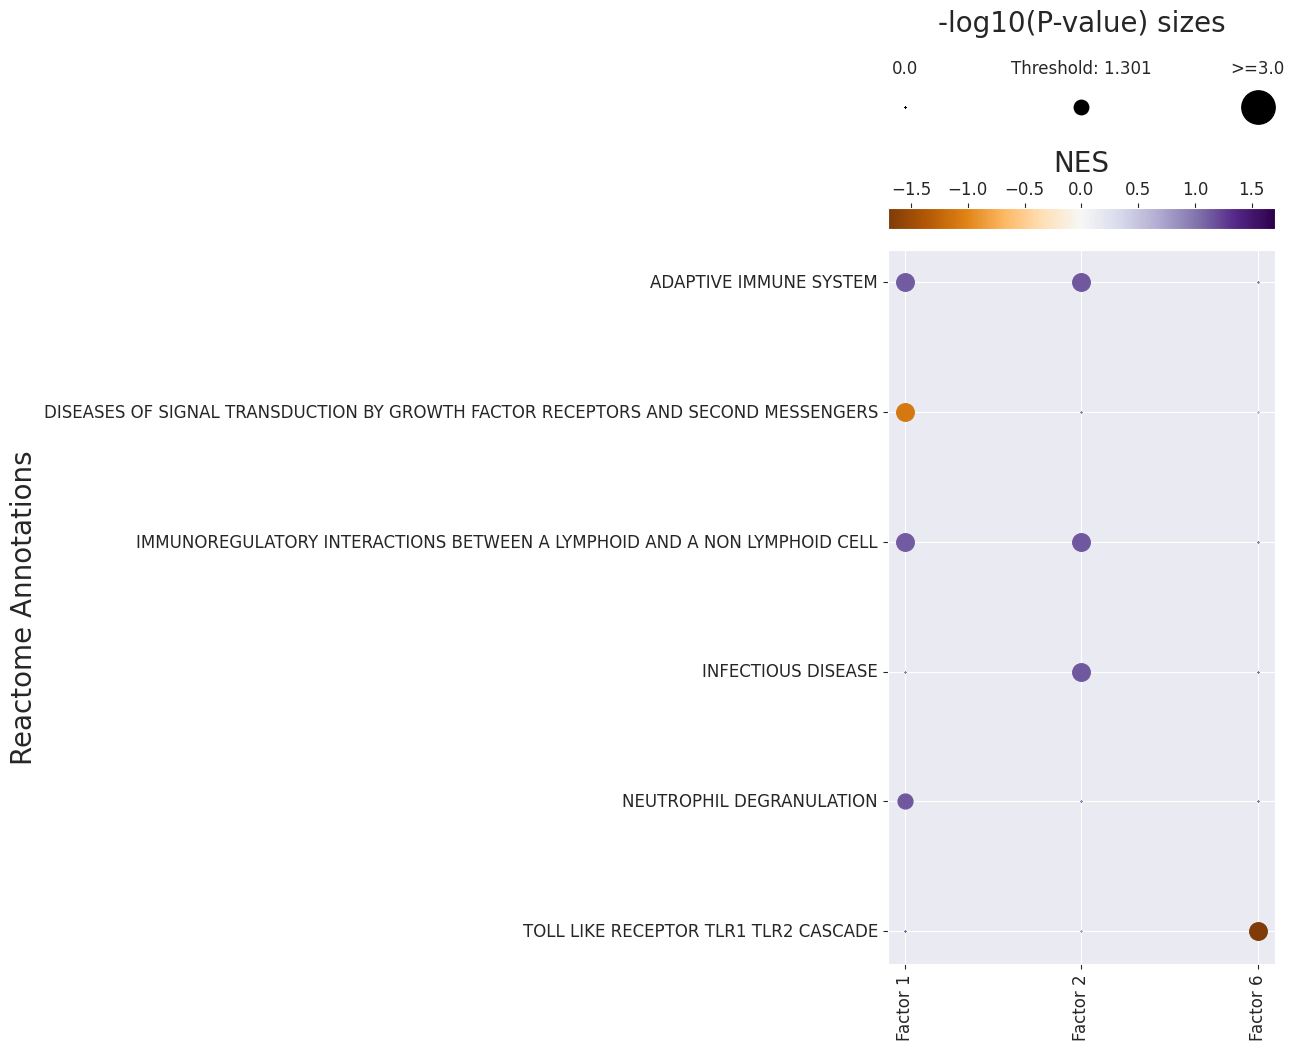

In [44]:
pathway_label = '{} Annotations'.format(pathwaydb)
fig_filename = output_folder + '/GSEA-Dotplot.pdf'

with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pvals,
                                                      score_df=scores,
                                                      significance=0.05,
                                                      xlabel='',
                                                      ylabel='{} Annotations'.format(pathwaydb),
                                                      cbar_title='NES',
                                                      cmap='PuOr',
                                                      figsize=(5, 12),
                                                      label_size=20,
                                                      title_size=20,
                                                      tick_size=12,
                                                      filename=fig_filename
                                                      )

### Footprint Enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity [(Dugourd and Saez-Rodriguez, 2019)](https://www.sciencedirect.com/science/article/pii/S2452310019300149).

In this case, we will use the PROGENy pathway resource to perform footprint enrichment analysis. PROGENy was built in a data-driven manner using perturbation and cancer lineage data [(Schubert et al, 2019)](https://www.nature.com/articles/s41467-017-02391-6#Sec8), as a consequence it also assigns different importances or weights to each gene in its pathway genesets. To this end, we need an enrichment method that can take weights into account, and here we will use multi-variate linear models from the `decoupler-py` package to perform this analysis [(Badia-i-Mompel et al., 2022)](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613).

Let’s load the PROGENy genesets and then convert them to sets of weighted ligand-receptor pairs:

In [46]:
# We first load the PROGENy gene sets
net = dc.get_progeny(organism='human', top=5000)

# Then convert them to sets with weighed ligand-receptor pairs
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")

Next, we can run the footprint enrichment analysis:

In [47]:
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(),
                              lr_progeny,
                              source="source",
                              target="interaction",
                              use_raw=False)

Finally, we can visualize the results:

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 47 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48, 49, 51, 53, 54, 55, 57, 58, 68, 69, 70, 71, 72, 74, 76, 78, 79, 81, 82, 83, 85, 86, 87, 91, 92, 3228]
Closed glyph list over 'GSUB': 47 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one

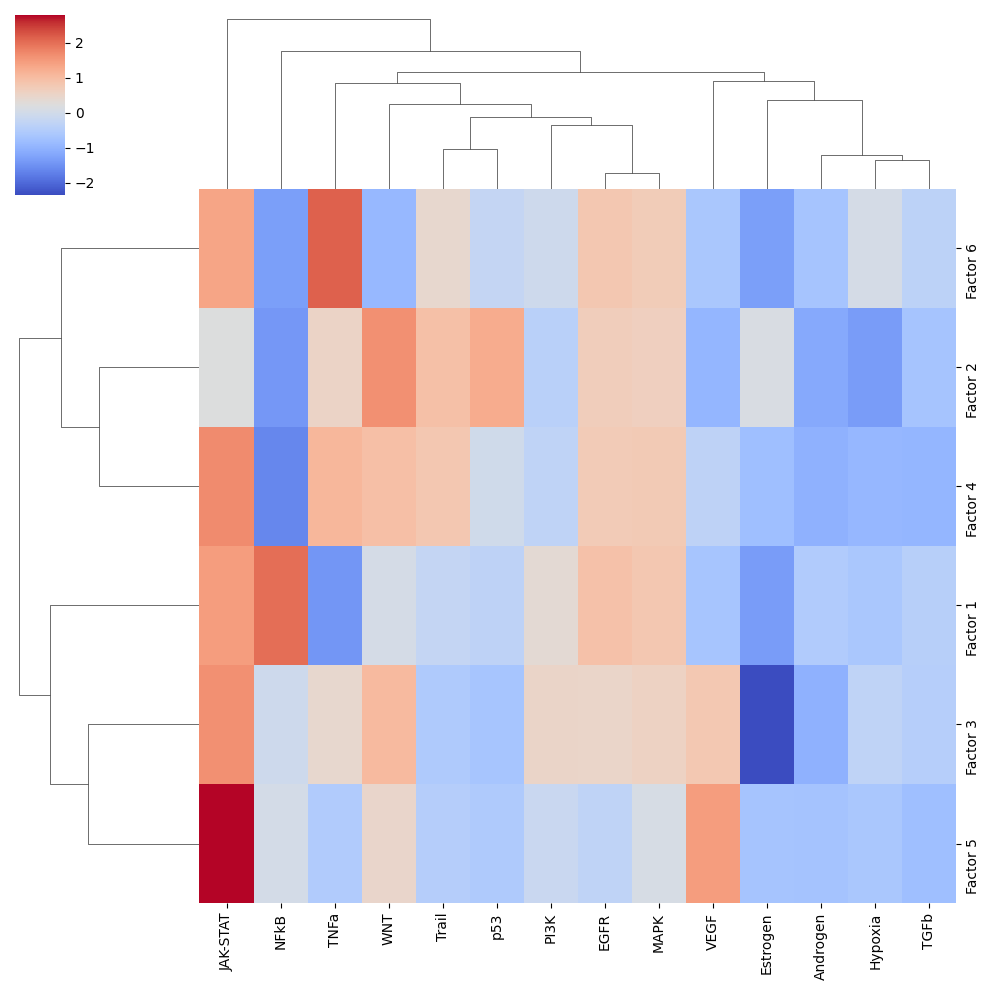

In [48]:
fig_filename = output_folder + '/PROGENy.pdf'
_ = sns.clustermap(estimate, xticklabels=estimate.columns, cmap='coolwarm', z_score=4)
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')

Let's zoom in on **Factor 5**, which was most associated with Interferon-beta stimulation.

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 49 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'v', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48, 49, 51, 53, 54, 55, 57, 58, 68, 69, 70, 71, 72, 74, 76, 78, 79, 81, 82, 83, 85, 86, 87, 89, 91, 92, 3228]
Closed glyph list over 'GSUB': 49 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmar

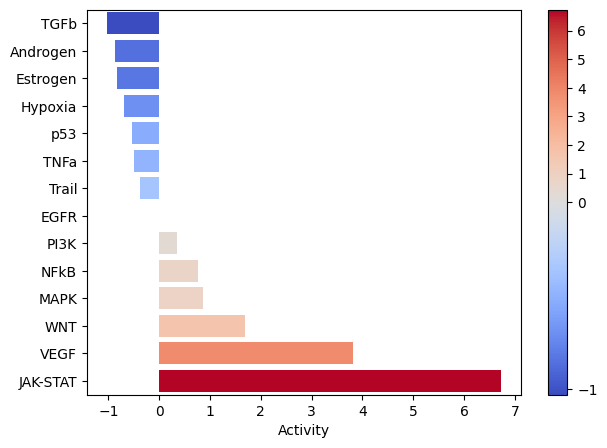

In [49]:
selected_factor = 'Factor 5'
fig_filename = output_folder + '/PROGENy-{}.pdf'.format(selected_factor.replace(' ', '-'))

dc.plot_barplot(estimate,
                selected_factor,
                vertical=True,
                cmap='coolwarm',
                save=fig_filename)